# A Times Series Analysis of Crime in Pittsburgh Pennsylvania

This notebook provides analysis of the police arrests and the crimes that have occurred in the city of Pittsburgh Pennsylvania.  The data being used comes from the Western Pennsylvania Regional Data Center and can be obtained by following this link https://data.wprdc.org/dataset/arrest-data.  In this notebook I address how to read in, clean, and manipulate a database, create visualizations to help understand and convey important features of the data, and carry out statistical modeling/analysis to discover trends that the data holds.
<br>Below is a photo of downtown Pittsburgh. The city of bridges! Lets begin!

<img src='pitt_downtown.jpg' width='800'>

import packages

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# see more columns and rows
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

read in and assess data of missing values

In [11]:
# read in data
arrests=pd.read_csv('pittsburgh_arrests_123119.csv')

# look at column types, missing values, identification numbers...
arrests.info()
print(arrests.isna().sum())
# Pk and CCR are identification values of individuals
print('\nnumber of unique PK: '+str(arrests['PK'].unique().shape))
print('number of unique CCR: '+str(arrests['CCR'].unique().shape))

arrests.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38158 entries, 0 to 38157
Data columns (total 16 columns):
PK                       38158 non-null int64
CCR                      38158 non-null int64
AGE                      37859 non-null float64
GENDER                   38158 non-null object
RACE                     38158 non-null object
ARRESTTIME               38158 non-null object
ARRESTLOCATION           38158 non-null object
OFFENSES                 38155 non-null object
INCIDENTLOCATION         38158 non-null object
INCIDENTNEIGHBORHOOD     36727 non-null object
INCIDENTZONE             38100 non-null object
INCIDENTTRACT            36749 non-null float64
COUNCIL_DISTRICT         33250 non-null float64
PUBLIC_WORKS_DIVISION    33250 non-null float64
X                        36810 non-null float64
Y                        36810 non-null float64
dtypes: float64(6), int64(2), object(8)
memory usage: 4.7+ MB
PK                          0
CCR                         0
AGE          

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y
0,1975272,16158872,42.0,F,B,2016-08-24T12:20:00,"4700 Block Centre AV Pittsburgh, PA 15213",3929 Retail Theft.,"4700 Block Centre AV Pittsburgh, PA 15213",Bloomfield,5,804.0,8.0,2.0,-79.949277,40.452551
1,1974456,16144120,31.0,M,W,2016-08-03T14:55:00,"4200 Block Steubenville PKE Pittsburgh, PA 15205",13(a)(16) Possession of Controlled Substance,"4200 Block Steubenville PKE Pittsburgh, PA 15205",Outside City,OSC,5599.0,NaN,NaN,-80.088018,40.440136
2,1974466,16144165,63.0,F,B,2016-08-03T16:45:00,"900 Block Freeport RD Fox Chapel, PA 15238",3929 Retail Theft.,"900 Block Freeport RD Fox Chapel, PA 15238",Westwood,5,2811.0,9.0,2.0,-79.891803,40.486625
3,1974550,16145257,25.0,F,W,2016-08-05T02:36:00,"Foreland ST & Cedar AV Pittsburgh, PA 15212",5503 Disorderly Conduct. / 5505 Public Drunken...,"Foreland ST & Cedar AV Pittsburgh, PA 15212",East Allegheny,1,2304.0,1.0,1.0,-80.001939,40.454080
4,1974596,16145962,25.0,M,B,2016-08-06T02:00:00,"900 Block Woodlow ST Pittsburgh, PA 15205",2702 Aggravated Assault. / 2705 Recklessy Enda...,"900 Block Woodlow ST Pittsburgh, PA 15205",Crafton Heights,5,2814.0,2.0,5.0,-80.052204,40.445900


# Data Cleaning

In [12]:
# remove nans in offenses
arrests = arrests[pd.notnull(arrests['OFFENSES'])]
# drop CCR value repeats
arrests=arrests.drop_duplicates(subset='CCR',keep='first')
# convert arrest times to datetime values and sort
arrests['ARRESTTIME'] = pd.to_datetime(arrests['ARRESTTIME'], yearfirst=True)
arrests= arrests.sort_values(by= ['ARRESTTIME']).reset_index(drop=True)


In [13]:
# look at arrest totals
print('arrest totals per year')
for yr in np.arange(1998,2021,1):
    print(str(yr)+': '+str(len(arrests.loc[arrests['ARRESTTIME'].dt.year==yr])))

arrest totals per year
1998: 1
1999: 0
2000: 0
2001: 0
2002: 0
2003: 0
2004: 0
2005: 1
2006: 1
2007: 3
2008: 1
2009: 0
2010: 0
2011: 2
2012: 1
2013: 2
2014: 6
2015: 10
2016: 3564
2017: 9927
2018: 8890
2019: 8733
2020: 166


In this instance I want data from September 2016 up until and including December 2019. September was when this data began to be tabulated according to https://data.wprdc.org/dataset/arrest-data.

In [14]:
#select data pertaining to desired time frame
arrests=arrests.loc[arrests['ARRESTTIME']>= '2016-09'].reset_index(drop=True)
arrests=arrests.loc[arrests['ARRESTTIME']< '2020-01'].reset_index(drop=True)

There are a lot of missing x,y coordinates.  This is because sex crimes do not receive coordinates as to where it happened, rather it is assigned the police zone location.  A mapping dictionary was created to assign x,y coordinates to police zone values to fill the missing data regarding sex crimes.

In [15]:
# I looked up police zone coordinates
# 1
# Latitude:	40.4569565
# Longitude:	-80.0160637
# 2
# Latitude:	40.4435808
# Longitude:	-79.9800111
# 3
# Latitude:	40.421685
# Longitude:	-79.9924763
# 4
# Latitude:	40.4414787
# Longitude:	-79.9212047
# 5
# Latitude:	40.4742729
# Longitude:	-79.9091618
# 6
# Latitude:	40.4420734
# Longitude:	-80.0322484


X_coord = {'Zone 1': -80.0160637 , 'Zone 2': -79.9800111, 'Zone 3': -79.9924763, 'Zone 4':-79.9212047 ,
           'Zone 5':-79.9091618 , 'Zone 6':-80.0322484 }

Y_coord = {'Zone 1': 40.4569565, 'Zone 2': 40.4435808 , 'Zone 3': 40.421685, 'Zone 4': 40.4414787 ,
           'Zone 5': 40.4742729, 'Zone 6':40.4420734 }
    
# map zone coordinates to all incident locations labeled with a zone description.
# if not 'zone', puts NaN                      
arrests['ZONEX'] = arrests['INCIDENTLOCATION'].map(X_coord)
arrests['ZONEY'] = arrests['INCIDENTLOCATION'].map(Y_coord)

# fills in x,y coordinates of zone incident locations
arrests['X']=arrests['X'].fillna(arrests['ZONEX'], axis=0)
arrests['Y']=arrests['Y'].fillna(arrests['ZONEY'], axis=0)
# remove ZONEX and ZONEY columns
arrests = arrests.drop(['ZONEX'], axis=1)
arrests = arrests.drop(['ZONEY'], axis=1)

print('missing x coordinates: '+str(len(arrests.loc[arrests['X'].isna()])))


missing x coordinates: 8


The missing coordinates belong to out of city locations.

In [16]:
# remove incidents that occur outside of Pittsburgh
print(arrests.loc[arrests['X'].isna()]['INCIDENTLOCATION'].unique())
# remove mislabeled and/or data entry error.
arrests=arrests[arrests['INCIDENTLOCATION'] !='Zone OSC']
arrests=arrests[arrests['INCIDENTLOCATION'] !='Zone ']
print('missing x coordinates: '+str(len(arrests.loc[arrests['X'].isna()])))


['Zone OSC' 'Zone ']
missing x coordinates: 0


The column labeled offenses contains all the charges of the individual upon arrest separated by a /

In [17]:
arrests['OFFENSES'].head()

0    2706 Terroristic Threats. / 5104 Resisting Arr...
1    2702 Aggravated Assault. / 2706 Terroristic Th...
2                                   9501 Bench Warrant
3    13(a)(16) Possession of Controlled Substance /...
4                              3934 Theft from Vehicle
Name: OFFENSES, dtype: object

I count the total number of charges per arrest per individual and also create a dataframe that records each charge per each individual.

In [18]:
# find total number of offenses per individual
arrests['NUMOFFENSES'] = arrests['OFFENSES'].apply(lambda x: len(x.split(' / ')))# records the indivdiual charges pertaining to each felon 
df=[]
for index, row in arrests.iterrows():
    # each offense is separated by a ''/''.  Split on this.
    charges = row['OFFENSES'].split(' / ')
    for charge in charges:
        row['CHARGES']=charge
        df.append(row)
        row=row.drop('CHARGES',axis=0)
        
arrests_cleaned=pd.DataFrame(df).reset_index(drop=True)
# isinstance(arrests_cleaned, pd.DataFrame) # check if dataframe was made
arrests_cleaned.head()

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,OFFENSES,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y,NUMOFFENSES,CHARGES
0,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA",2706 Terroristic Threats. / 5104 Resisting Arr...,"E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,2706 Terroristic Threats.
1,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA",2706 Terroristic Threats. / 5104 Resisting Arr...,"E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,5104 Resisting Arrest or Other Law Enforcement.
2,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA",2706 Terroristic Threats. / 5104 Resisting Arr...,"E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,13(a)(31) Marijuana: Possession Small Amount
3,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA",2706 Terroristic Threats. / 5104 Resisting Arr...,"E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,3802(a)(1) DUI - General Impairment
4,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA",2706 Terroristic Threats. / 5104 Resisting Arr...,"E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,3802(c) DUI - Highest Rate of Alcohol - BAC >=...


Nice! Now the new dataframe can be cleaned up.  I assign the dates of arrests as the index.  This will greatly help in analysis moving forward using Python's Pandas package.

In [19]:
# remove period
arrests_cleaned['CHARGES'] = arrests_cleaned['CHARGES'].str.replace('.','',regex=True) # remove period from string
# make column for arrest codes
arrests_cleaned['ARRESTCODE'] = arrests_cleaned['CHARGES'].apply(lambda x: x.split(" ",1)[0])
# make column for arrest descriptions
arrests_cleaned['ARRESTDESCRIPT'] = arrests_cleaned['CHARGES'].apply(lambda x: x.split(" ",1)[1])

# remove unwanted columns
arrests_cleaned = arrests_cleaned.drop(['CHARGES','OFFENSES'],axis=1)
# arrests_cleaned = arrests_cleaned.drop(['OFFENSES'],axis=1)
# make index relfective of arrest times
arrests_cleaned.index = arrests_cleaned['ARRESTTIME']
del arrests_cleaned.index.name
# arrests_cleaned.to_csv('arrests_cleaned.csv', index=False)
arrests_cleaned.head()

,PK,CCR,AGE,GENDER,RACE,ARRESTTIME,ARRESTLOCATION,INCIDENTLOCATION,INCIDENTNEIGHBORHOOD,INCIDENTZONE,INCIDENTTRACT,COUNCIL_DISTRICT,PUBLIC_WORKS_DIVISION,X,Y,NUMOFFENSES,ARRESTCODE,ARRESTDESCRIPT
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,2706,Terroristic Threats
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,5104,Resisting Arrest or Other Law Enforcement
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,13(a)(31),Marijuana: Possession Small Amount
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,3802(a)(1),DUI - General Impairment
2016-09-01 01:06:00,1975503,16164356,32.0,F,B,2016-09-01 01:06:00,"E Liberty BL & Centre AV Pittsburgh, PA","E Liberty BL & Centre AV Pittsburgh, PA",Homewood North,5,1301.0,9.0,2.0,-79.919932,40.465012,7,3802(c),DUI - Highest Rate of Alcohol - BAC >= 16%


In [21]:
# # previously saved csv
# arrests_cleaned=pd.read_csv('arrests_cleaned.csv')
# arrests_cleaned['ARRESTTIME'] = pd.to_datetime(arrests_cleaned['ARRESTTIME'], yearfirst=True)
# arrests_cleaned.index = arrests_cleaned['ARRESTTIME']
# del arrests_cleaned.index.name
# arrests_cleaned.head()

# Data Analysis
Now I will begin to look at what charges are being assigned to arrests.

In [23]:
# count the number of individual charges and how they compare to all the others.
charge_info=arrests_cleaned['ARRESTDESCRIPT'].value_counts()
charge_info=pd.DataFrame(charge_info).reset_index()
charge_info=charge_info.rename(columns={'index': 'crime', 'ARRESTDESCRIPT': 'count'})
charge_info['cumsum']=charge_info['count'].cumsum()
charge_info['overall_pct']=(charge_info['count']/charge_info['count'].sum())*100
charge_info['cumsum_pct']=charge_info['overall_pct'].cumsum()
charge_info.head()

,crime,count,cumsum,overall_pct,cumsum_pct
0,Simple Assault,4561,4561,6.137471,6.137471
1,Possession of Controlled Substance,4559,9120,6.134779,12.272250
2,Paraphernalia - Use or Possession,4279,13399,5.758000,18.030250
3,Bench Warrant,3442,16841,4.631698,22.661948
4,Marijuana: Possession Small Amount,2871,19712,3.863337,26.525285


A bar graph visualization will help better see these values.  Let's evaluate the top 20 charges.

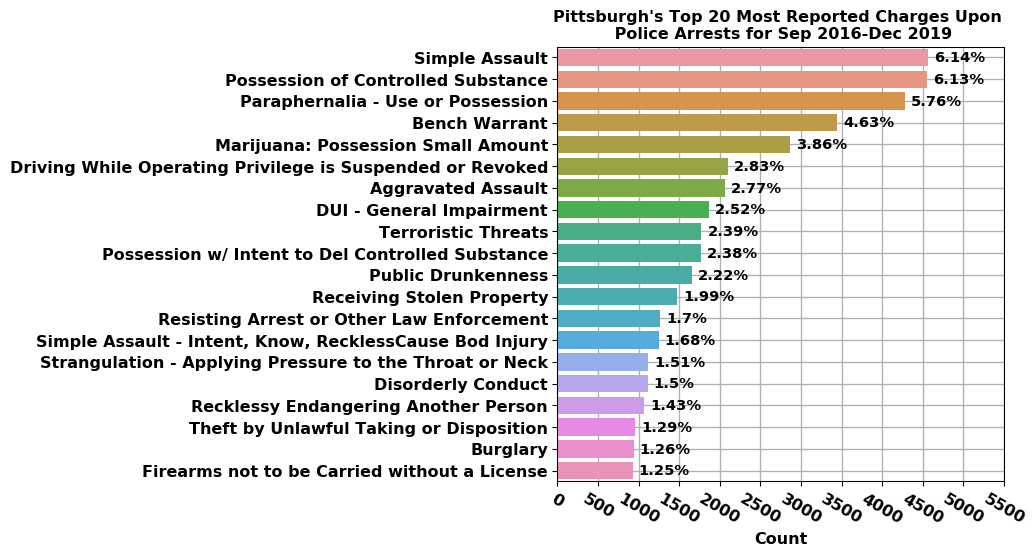

In [24]:
# barplot of top 20 most reported charges with arrests
fig = plt.figure(figsize=(6, 6), dpi=96)
barplt = fig.add_subplot(1, 1, 1)  # create an axes object in the figure

barplt = sns.barplot(y='crime', x='count', data=charge_info.loc[0:19])

fontsize=12
barplt.set_title("Pittsburgh's Top 20 Most Reported Charges Upon \n Police Arrests for Sep 2016-Dec 2019",
                 weight='bold',fontsize=fontsize)
barplt.set_ylabel('',fontweight='bold',fontsize=fontsize)
barplt.set_xlabel('Count',fontweight='bold',fontsize=fontsize)
    
barplt.set_xticks(np.arange(0,6000,500))

# fontsize=28
for tick in barplt.xaxis.get_ticklabels():
        tick.set(rotation=-30)
        tick.set_fontsize(fontsize)
        tick.set_fontweight('bold')
for tick in barplt.yaxis.get_ticklabels():
    tick.set_fontsize(fontsize)
    tick.set_fontweight('bold')
    
barplt.grid(linewidth=1)
# set bars in front of grid lines
barplt.set_axisbelow(True)
                 
# Add transparency to colors if need be
for patch in barplt.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))

# add perecentages
j=0
for i in barplt.patches:
    barplt.text(i.get_width()+75, i.get_y()+.6, 
                str(round(charge_info['overall_pct'].iloc[j],2))+'%',
                fontsize=11, fontweight='bold', color='black')
    j=j+1

# plt.savefig('arrests_top_20_total_pct.png',bbox_inches='tight')
plt.show()

The percentage value associated with each crime represents the percentage of that crime in relation to all total crimes committed over the time span.  It seems that assault and drug related charges dominate arrests.  A good question to investigate is whether an arrest has multiple charges or a single charge associated with them.  I will break down the information into monthly values.

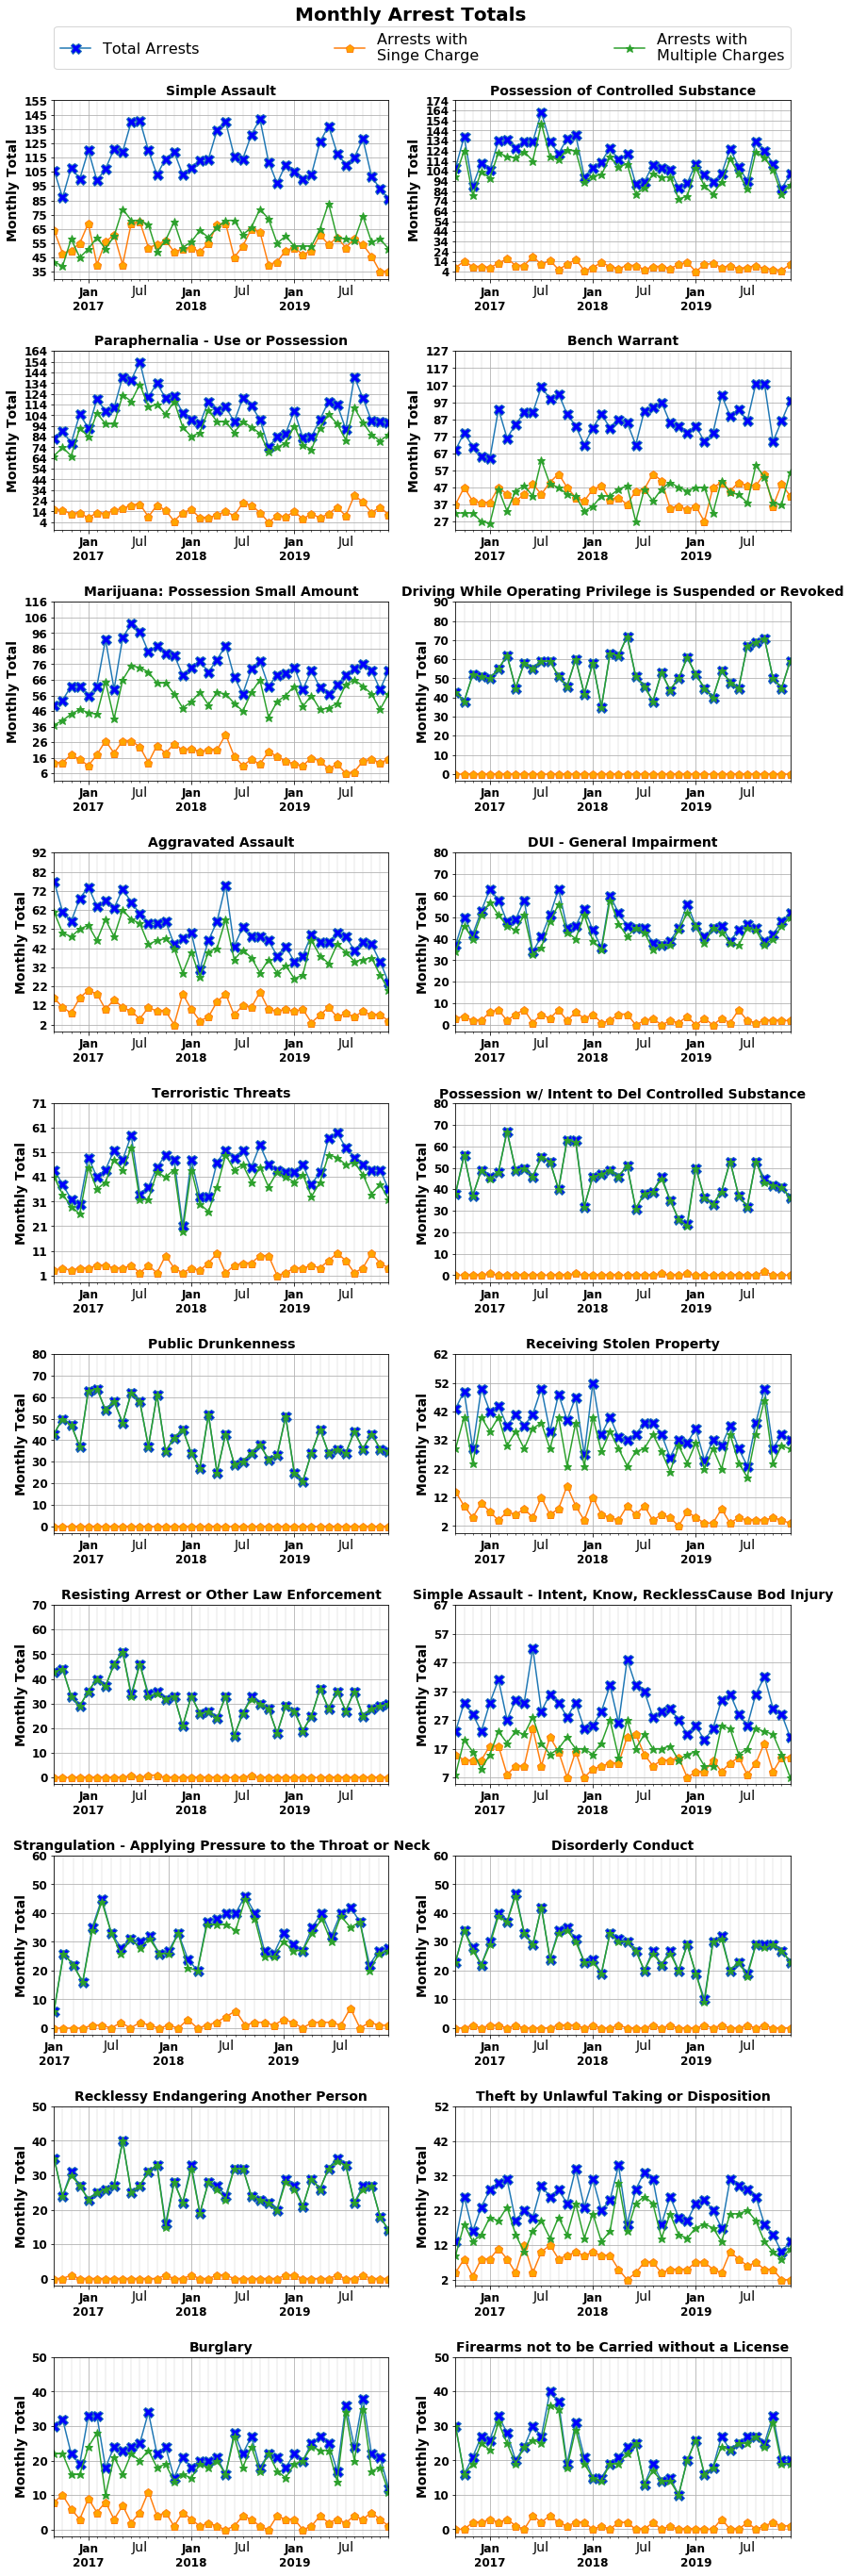

In [25]:
fig = plt.figure(figsize=(14,46))
sup_title=fig.suptitle('Monthly Arrest Totals',fontsize=20, fontweight='bold')

fontsize=14

for i,crime in enumerate(charge_info['crime'].iloc[0:20]):

    i=i+1
# find data to plot
    individ_crime = arrests_cleaned.loc[arrests_cleaned['ARRESTDESCRIPT']== crime]
    individ_month_arrests=individ_crime.resample('M').agg(dict(NUMOFFENSES='count'))
    individ_crime_single_total = individ_crime[individ_crime['NUMOFFENSES'] == 1]
    individ_month_arrests['SINGLECHARGES'] =individ_crime_single_total.resample('M').agg(dict(NUMOFFENSES='count'))
    individ_crime_multiple_total = individ_crime[individ_crime['NUMOFFENSES'] != 1]
    individ_month_arrests['MULTIPLECHARGES']=individ_crime_multiple_total.resample('M').agg(dict(NUMOFFENSES='count'))
    individ_month_arrests['DATE'] = individ_month_arrests.index
    individ_month_arrests=individ_month_arrests.fillna(0)
# plot data
    ax=fig.add_subplot(10,2,i)
    individ_month_arrests.plot(x='DATE',y='NUMOFFENSES',marker='X',markersize=11, markerfacecolor='blue',
                               ax=ax, label='Total Arrests',legend=False)
    individ_month_arrests.plot(x='DATE',y='SINGLECHARGES',marker='p',markersize=9, markerfacecolor='orange',
                               ax=ax, label='Arrests with \nSinge Charge', legend=False)
    individ_month_arrests.plot(x='DATE',y='MULTIPLECHARGES',marker='*',markersize=9,
                               ax=ax, label='Arrests with \nMultiple Charges', legend=False)
    
    ax.set_title(crime,fontsize=fontsize,fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Monthly Total',fontsize=fontsize,fontweight='bold')
    ax.set_yticks(np.arange(min(individ_month_arrests['SINGLECHARGES']), max(individ_month_arrests['NUMOFFENSES'])+20, 10))

    for tick in ax.xaxis.get_ticklabels():
        tick.set(rotation=0)
        tick.set_fontweight('bold')
        tick.set_fontsize(12)
    for tick in ax.yaxis.get_ticklabels():
        tick.set_fontweight('bold')
        tick.set_fontsize(12)
    
    ax.tick_params(axis='x', which='minor', labelsize=14)
    ax.grid(b=True,which='major', linewidth=.8)
    ax.grid(b=True,which='minor', linewidth=.3)
    # end points brought to front
    ax.axes.get_xaxis().set_visible(True)


fig.subplots_adjust(bottom=.1, hspace=0.4, wspace=0.2)
sup_title.set_y(0.91)
# global legend
bbox = (fig.subplotpars.left, fig.subplotpars.top+.01, fig.subplotpars.right-fig.subplotpars.left,.1)
ax.legend(bbox_to_anchor=bbox, mode='expand', loc='lower left', ncol=3, 
          borderaxespad=0., bbox_transform=fig.transFigure, fontsize=16)


# plt.savefig('top20month.png',bbox_inches='tight')
plt.show()

The plot of marijuana possession under 30 grams is interesting because there is an underlying occurrence of arrests with only that charge.  Let's look more closely at this.

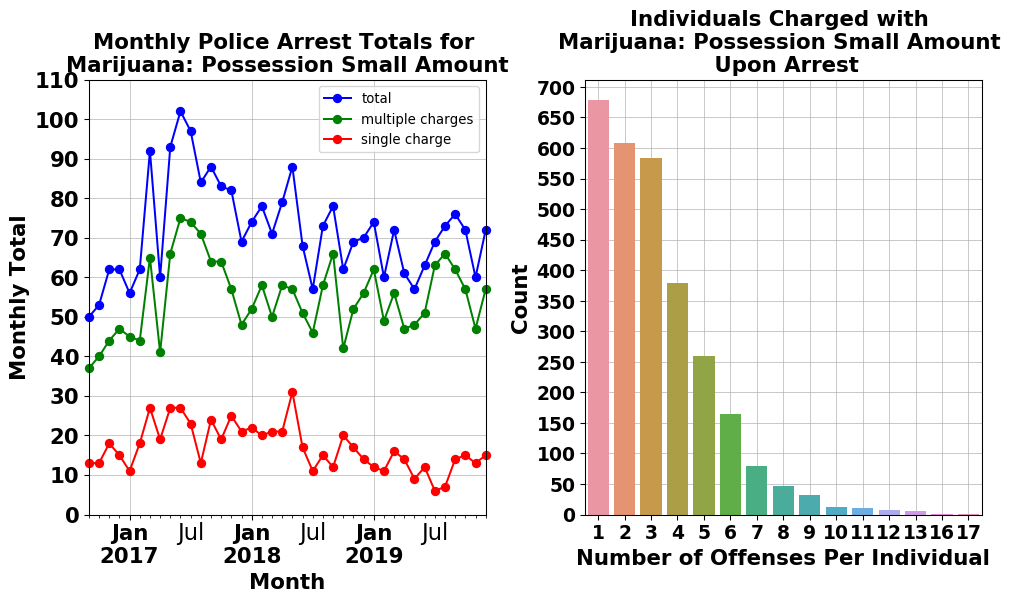

'Marijuana: Possession Small Amount'

In [26]:
crime_name=charge_info['crime'].iloc[4] # marijuana location name

individ_crime = arrests_cleaned.loc[arrests_cleaned['ARRESTDESCRIPT']== crime_name]
individ_month_arrests=individ_crime.resample('M').agg(dict(NUMOFFENSES='count'))
individ_crime_single_total = individ_crime[individ_crime['NUMOFFENSES'] == 1]
individ_month_arrests['SINGLECHARGES'] =individ_crime_single_total.resample('M').agg(dict(NUMOFFENSES='count'))
individ_crime_multiple_total = individ_crime[individ_crime['NUMOFFENSES'] != 1]
individ_month_arrests['MULTIPLECHARGES']=individ_crime_multiple_total.resample('M').agg(dict(NUMOFFENSES='count'))
individ_month_arrests['DATE'] = individ_month_arrests.index
# individ_month_arrests=individ_month_arrests.fillna(0)


# plot data
from matplotlib import gridspec
fig = plt.figure(figsize=(12,6), dpi=96)
grid = fig.add_gridspec(ncols=2, nrows=1,wspace=0.25)#, width_ratios=widths, height_ratios=heights,left=0.05, right=0.48, wspace=0.05)

# ax = plt.gca()
xy = fig.add_subplot(grid[0, 0])
ax1 = individ_month_arrests['NUMOFFENSES'].plot(label='total', marker='o',color='b', clip_on = False,ax=xy)
ax2 = individ_month_arrests['MULTIPLECHARGES'].plot(label='multiple charges', marker='o',color='g', clip_on = False)
ax3 = individ_month_arrests['SINGLECHARGES'].plot(label='single charge', marker='o',color='r', clip_on = False)
                            
ax1.legend(loc=1)
ax2.legend(loc=1)
ax3.legend(loc=1)

xy.set_xlabel('Month',fontsize=16,fontweight='bold')
xy.set_ylabel('Monthly Total',fontsize=16,fontweight='bold')
xy.set_title('Monthly Police Arrest Totals for \n'+crime_name,fontsize=16, fontweight='bold')
xy.tick_params(axis='both', which='major', labelsize=16)
xy.tick_params(axis='x', which='minor', labelsize=17)
for tick in xy.xaxis.get_ticklabels():
        tick.set(rotation=0)
        tick.set_fontweight('bold')
for tick in xy.yaxis.get_ticklabels():
    tick.set_fontweight('bold')
xy.grid(linewidth=.5)
xy.set_yticks(np.arange(0,120,10))

xy = fig.add_subplot(grid[0, 1])
mj= sns.countplot(x="NUMOFFENSES", data=arrests_cleaned.loc[arrests_cleaned['ARRESTDESCRIPT']==crime_name])
mj.set_xlabel('Number of Offenses Per Individual',fontsize=16,fontweight='bold')
mj.set_ylabel('Count',fontsize=16,fontweight='bold')
mj.set_title('Individuals Charged with \n'+crime_name+' \n Upon Arrest',fontsize=16, fontweight='bold')
mj.tick_params(axis='both', which='major', labelsize=14)
mj.tick_params(axis='x', which='minor', labelsize=12)
for tick in mj.xaxis.get_ticklabels():
        tick.set(rotation=0)
        tick.set_fontweight('bold')
for tick in mj.yaxis.get_ticklabels():
    tick.set_fontweight('bold')
mj.grid(linewidth=.5)
mj.set_axisbelow(True)
mj.set_yticks(np.arange(0,750,50))

# plt.savefig('arrests_specific.png',bbox_inches='tight')
plt.show()

crime_name

In [27]:
individ_month_arrests['SINGLECHARGES'].sum()/len(individ_month_arrests)

16.95

The graphs show that close to 700 (678 approximately) people were arrested solely for possession of marijuana of less than 30 grams since September 2016 to December 2019.  That's approximately 17 arrest per month.  It seems that arrests with single charge drops after June 2018. Let's explore this.

In [28]:
import warnings
warnings.filterwarnings('ignore')
upto_june2018=individ_month_arrests.loc['2017-01':'2018-06']
upto_june2018['ID']='up to june 2018'
after_june2018=individ_month_arrests.loc['2018-07':]
after_june2018['ID'] = 'after june 2018'
labeled=pd.concat([upto_june2018,after_june2018])
labeled.head()


,NUMOFFENSES,SINGLECHARGES,MULTIPLECHARGES,DATE,ID
2017-01-31,56,11,45,2017-01-31,up to june 2018
2017-02-28,62,18,44,2017-02-28,up to june 2018
2017-03-31,92,27,65,2017-03-31,up to june 2018
2017-04-30,60,19,41,2017-04-30,up to june 2018
2017-05-31,93,27,66,2017-05-31,up to june 2018


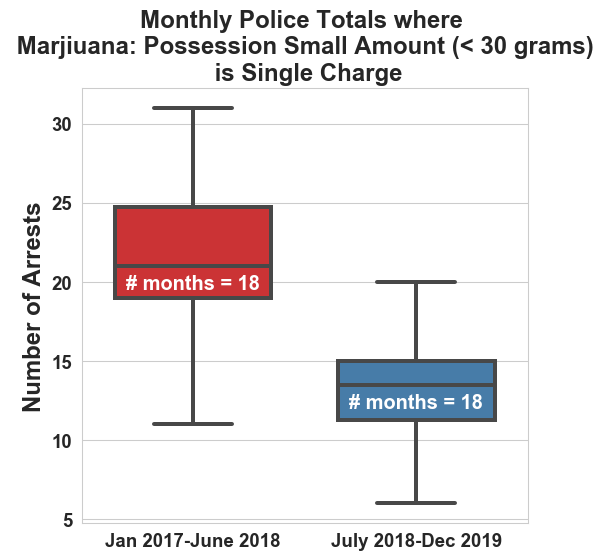

In [34]:
plt.figure(figsize=(6,6), dpi=96)
sns.set_style("whitegrid")
boxplt = sns.boxplot(x='ID',y='SINGLECHARGES',
                     data=labeled,
                     palette='Set1',
                     width=0.7,
                     linewidth=3,
                     fliersize=0,
                     whis=1.5)

fontsize=18
boxplt.set_title('Monthly Police Totals where \n Marjiuana: Possession Small Amount (< 30 grams) \n is Single Charge',fontsize=18, fontweight='bold')
boxplt.set_ylabel('Number of Arrests',fontweight='bold',fontsize=fontsize)
boxplt.set_xlabel('',fontweight='bold',fontsize=fontsize)
    
# barplt.set_xticks(np.arange(0,8,1))

fontsize=14
for tick in boxplt.xaxis.get_ticklabels():
        tick.set(rotation=0)
        tick.set_fontsize(fontsize)
        tick.set_fontweight('bold')
for tick in boxplt.yaxis.get_ticklabels():
    tick.set_fontsize(fontsize)
    tick.set_fontweight('bold')
    
    # Add transparency to colors
for patch in boxplt.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 1))
    
    
# Calculate number of obs per group & median to position labels
medians = labeled.groupby(['ID'])['SINGLECHARGES'].median().values
nobs = labeled.groupby("ID").size().values
plt.text(0,medians[1]-1.5, '# months = ' + str(nobs[1]), horizontalalignment='center', color='w', fontsize=15, fontweight='bold')
plt.text(1,medians[0]-1.5, '# months = ' + str(nobs[0]), horizontalalignment='center', color='w', fontsize=15, fontweight='bold')

xtic=['Jan 2017-June 2018', 'July 2018-Dec 2019']
boxplt.set_xticklabels(xtic)
# plt.savefig('boxplt2017.png',bbox_inches='tight')
plt.show()

Yup it looks like there is a difference in means. Let's approach this from a statistics viewpoint. The null hypothesis of that there is no difference in single charge monthly arrest totals between Jan 2017-June 2018 and after June 2018. 

In [35]:
# describe values
print(upto_june2018['SINGLECHARGES'].describe())
print('')
print(after_june2018['SINGLECHARGES'].describe())

count    18.000000
mean     21.444444
std       5.043601
min      11.000000
25%      19.000000
50%      21.000000
75%      24.750000
max      31.000000
Name: SINGLECHARGES, dtype: float64

count    18.000000
mean     12.944444
std       3.438061
min       6.000000
25%      11.250000
50%      13.500000
75%      15.000000
max      20.000000
Name: SINGLECHARGES, dtype: float64


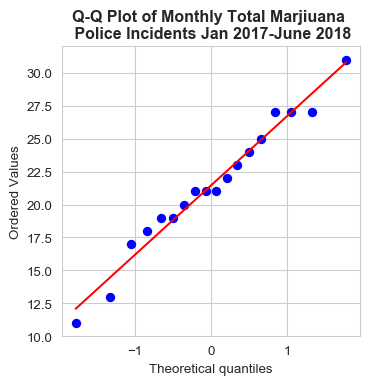

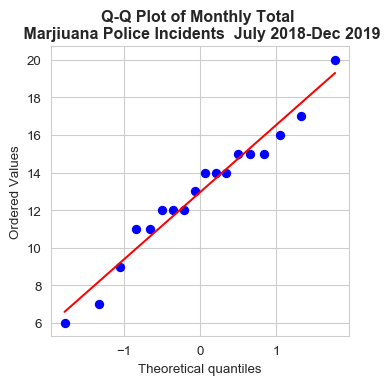

In [36]:
# first test for normality using qq plots
import scipy
fig= plt.figure(figsize=(4,4), dpi=96)
b4 = scipy.stats.probplot(upto_june2018['SINGLECHARGES'], plot= plt)
plt.title('Q-Q Plot of Monthly Total Marjiuana \n Police Incidents Jan 2017-June 2018', fontweight='bold')
plt.savefig('b4june2018.png',bbox_inches='tight')
plt.show()

fig= plt.figure(figsize=(4,4), dpi=96)
aft = scipy.stats.probplot(after_june2018['SINGLECHARGES'], plot= plt)
plt.title('Q-Q Plot of Monthly Total \n Marjiuana Police Incidents  July 2018-Dec 2019', fontweight='bold')
plt.savefig('afterjune2018.png',bbox_inches='tight')
plt.show()

Both seem to come from a normal distribution.  A Shapiro-Wilks test for normality will be calculated.

In [37]:
# show p value of test
print(scipy.stats.shapiro(upto_june2018['SINGLECHARGES'])[1])
print('')
print(scipy.stats.shapiro(after_june2018['SINGLECHARGES'])[1])

0.9129541516304016

0.8150143623352051


Both p-values are greater than 0.05.  Both confirm normality.  Lets test for equal variance between the two using Levene's test.

In [38]:
print(scipy.stats.levene(upto_june2018['SINGLECHARGES'], after_june2018['SINGLECHARGES']))

LeveneResult(statistic=1.5843195266272185, pvalue=0.21671395029031792)


p-value  greater than 0.05. confirms equal variance.

Knowing that normality and equal variance is satisfied, a student's t-test can be computed.

In [39]:
# have equal sample size and variance, use students t test
scipy.stats.ttest_ind(upto_june2018['SINGLECHARGES'], after_june2018['SINGLECHARGES'], equal_var = True)

Ttest_indResult(statistic=5.908053490296667, pvalue=1.1336400906252983e-06)

The p-value is less than 0.05, therefore we reject the null hypothesis that there's no difference between the means and conclude that a significant difference does exist.  

So why the decrease in singe charge arrests of marijuana? Was it because of the legislature that was passed giving law enforcement to write possession as a fine and not a misdemeanor? Are Pittsburgh citizens just not breaking the law? (probably not!) Analysis of arrest times and location to come. Stay tuned.